# 以TP53为Target 蛋白进行Drug discovery分析

采用ChEMBL数据库，获取实验数据

## 下载数据

In [ ]:
! pip install --ignore-installed chembl_webresource_client

导入依赖包

In [4]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

检索`TP53`在ChEMBL中的记录，选择正确的ID

In [7]:
# Target search for TP53
target = new_client.target
#Tumour suppressor p53/oncoprotein Mdm2： CHEMBL1907611
target_query = target.search('TP53')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Tumor suppressor p53-binding protein 1,15.0,False,CHEMBL2424509,"[{'accession': 'Q12888', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Mus musculus,TP53-binding protein 1,15.0,False,CHEMBL4295790,"[{'accession': 'P70399', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Homo sapiens,"Fructose-2,6-bisphosphatase TIGAR",15.0,False,CHEMBL4295958,"[{'accession': 'Q9NQ88', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,TP53-regulating kinase,14.0,False,CHEMBL1938223,"[{'accession': 'Q96S44', 'component_descriptio...",SINGLE PROTEIN,9606
4,"[{'xref_id': 'P02340', 'xref_name': None, 'xre...",Mus musculus,Cellular tumor antigen p53,13.0,False,CHEMBL4164,"[{'accession': 'P02340', 'component_descriptio...",SINGLE PROTEIN,10090
5,"[{'xref_id': 'P04637', 'xref_name': None, 'xre...",Homo sapiens,Cellular tumor antigen p53,12.0,False,CHEMBL4096,"[{'accession': 'P04637', 'component_descriptio...",SINGLE PROTEIN,9606
6,[],Homo sapiens,Cellular tumor antigen p53/Death-associated pr...,10.0,False,CHEMBL3885543,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
7,[],Homo sapiens,CREB-binding protein/p53,9.0,False,CHEMBL3301383,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
8,[],Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,8.0,False,CHEMBL1907611,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
9,[],Homo sapiens,Tumour suppressor protein p53/Mdm4,8.0,False,CHEMBL2221344,"[{'accession': 'P04637', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606


In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id='CHEMBL1907611').filter(standard_type="IC50")

In [6]:
df = pd.DataFrame.from_dict(res)
df.head(10)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1424130,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,27.0
1,None,1424131,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,66.0
2,None,1424132,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,90.0
3,None,1424135,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,85.0
4,None,1424136,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
5,None,1424137,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,70.0
6,None,1424233,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,15.9
7,None,1424234,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
8,None,1424235,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,14.0
9,None,1424236,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,26.2


输出数据

In [8]:
df.to_csv('TP53_activity_data.csv', index=False)

In [9]:
df.shape

(1494, 45)

## 数据预处理

去除NA值：

+ IC50

+ 分子式

In [10]:
#IC50 value
df2 = df[df.standard_value.notna()]
# 分子式
df2 = df2[df.canonical_smiles.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1424130,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,27.0
1,None,1424131,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,66.0
2,None,1424132,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,90.0
3,None,1424135,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,85.0
4,None,1424136,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,None,19446169,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.13
1490,None,19446170,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,506.0
1491,None,19446171,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.13
1492,None,19446172,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.01


去除重复

In [11]:
len(df2.canonical_smiles.unique())

1217

In [12]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1424130,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,27.0
1,None,1424131,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,66.0
2,None,1424132,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,90.0
3,None,1424135,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,85.0
4,None,1424136,[],CHEMBL828042,Inhibitory concentration against MDM2-p53 inte...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,None,19446168,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.0042
1489,None,19446169,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.13
1490,None,19446170,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,506.0
1491,None,19446171,[],CHEMBL4432632,Inhibition of C-terminal biotin-tagged strepta...,B,None,None,BAO_0000190,BAO_0000224,...,Homo sapiens,Tumour suppressor p53/oncoprotein Mdm2,9606,None,None,IC50,uM,UO_0000065,None,0.13


选择需要的数据信息

In [13]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,27000.0
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,66000.0
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,90000.0
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,85000.0
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,92000.0
...,...,...,...
1488,CHEMBL4465041,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,4.2
1489,CHEMBL3691737,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,130.0
1490,CHEMBL3691738,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,506000.0
1491,CHEMBL3687315,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,130.0


In [14]:
df3.to_csv('TP53_activity_data_preprocessed.csv', index=False)

### Simply EDA

In [5]:
df3=pd.read_csv("TP53_activity_data_preprocessed.csv")

bioactivity_threshold = []
for i in df3.standard_value:
  if float(i) >= 2270:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 5:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df4 = pd.concat([df3, bioactivity_class], axis=1)
df4

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,27000.0,inactive
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,66000.0,inactive
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,90000.0,inactive
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,85000.0,inactive
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,92000.0,inactive
...,...,...,...,...
1212,CHEMBL4465041,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,4.2,active
1213,CHEMBL3691737,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,130.0,intermediate
1214,CHEMBL3691738,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,506000.0,inactive
1215,CHEMBL3687315,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,130.0,intermediate


In [8]:
df4.standard_value.describe()

count    1.217000e+03
mean     2.949006e+04
std      9.784567e+04
min      6.100000e-02
25%      1.600000e+00
50%      5.000000e+01
75%      2.270000e+03
max      1.018000e+06
Name: standard_value, dtype: float64

boxplot图

In [ ]:
import seaborn as sns
sns.set_theme(style="white")

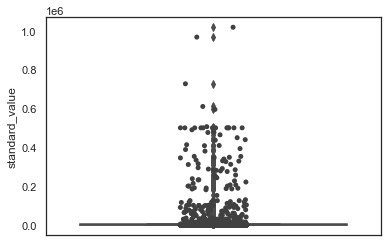

In [14]:
ax = sns.boxplot(y="standard_value", data=df4)
ax = sns.stripplot(y="standard_value",data=df4, color=".25")

密度分布图

E:\anaconda\envs\drug\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='standard_value', ylabel='Density'>

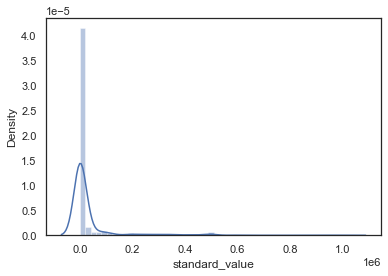

In [27]:
#sns.histplot(df4['standard_value'])
sns.distplot(df4['standard_value'])

E:\anaconda\envs\drug\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='standard_value', ylabel='Density'>

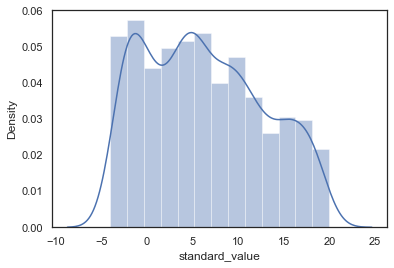

In [28]:
import numpy as np
#sns.histplot(np.log2(df4['standard_value']))
sns.distplot(np.log2(df4['standard_value']))

### 计算 Lipinski 

基于compound的分子式，进行druglikness的估算：

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

 a set of rule-of-thumb for evaluating the druglikeness of compounds

In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

E:\anaconda\envs\drug\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [7]:
df_lipinski = lipinski(df4.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,572.822,7.17210,1.0,4.0
1,426.560,5.48100,1.0,2.0
2,445.515,4.26000,1.0,5.0
3,449.594,5.02930,3.0,3.0
4,461.605,7.05800,0.0,2.0
...,...,...,...,...
1212,414.336,6.20654,1.0,2.0
1213,520.460,7.67774,0.0,4.0
1214,520.460,7.67774,0.0,4.0
1215,593.555,7.30972,0.0,6.0


In [16]:
df_combined = pd.concat([df4,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,27000.0,inactive,572.822,7.17210,1.0,4.0
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,66000.0,inactive,426.560,5.48100,1.0,2.0
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,90000.0,inactive,445.515,4.26000,1.0,5.0
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,85000.0,inactive,449.594,5.02930,3.0,3.0
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,92000.0,inactive,461.605,7.05800,0.0,2.0
...,...,...,...,...,...,...,...,...
1212,CHEMBL4465041,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,4.2,active,414.336,6.20654,1.0,2.0
1213,CHEMBL3691737,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,130.0,intermediate,520.460,7.67774,0.0,4.0
1214,CHEMBL3691738,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,506000.0,inactive,520.460,7.67774,0.0,4.0
1215,CHEMBL3687315,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,130.0,intermediate,593.555,7.30972,0.0,6.0


### IC50值转换

将原有的IC50进行LOG转换

In [42]:
import numpy as np
df_combined['logIC50']=[np.log10(m+1) for m in df_combined['standard_value']]
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors,logIC50
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,27000.0,inactive,572.822,7.17210,1.0,4.0,4.431380
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,66000.0,inactive,426.560,5.48100,1.0,2.0,4.819551
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,90000.0,inactive,445.515,4.26000,1.0,5.0,4.954247
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,85000.0,inactive,449.594,5.02930,3.0,3.0,4.929424
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,92000.0,inactive,461.605,7.05800,0.0,2.0,4.963793
...,...,...,...,...,...,...,...,...,...
1212,CHEMBL4465041,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,4.2,active,414.336,6.20654,1.0,2.0,0.716003
1213,CHEMBL3691737,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,130.0,intermediate,520.460,7.67774,0.0,4.0,2.117271
1214,CHEMBL3691738,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,506000.0,inactive,520.460,7.67774,0.0,4.0,5.704151
1215,CHEMBL3687315,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,130.0,intermediate,593.555,7.30972,0.0,6.0,2.117271


In [43]:
df_combined.logIC50.describe()

count    1217.000000
mean        2.079640
std         1.735690
min         0.025715
25%         0.414973
50%         1.707570
75%         3.356217
max         6.007748
Name: logIC50, dtype: float64

In [44]:
df_combined.to_csv('TP53_activity_data_3class_pIC50.csv')

### 可视化

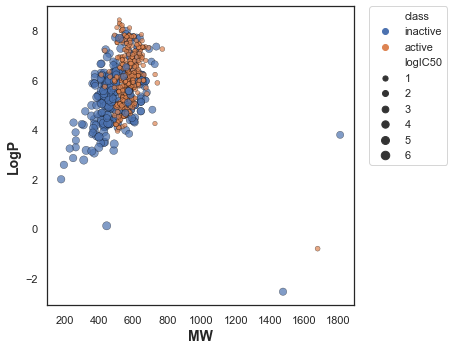

In [48]:
import matplotlib.pyplot as plt

df_2class=df_combined[df_combined['class']!="intermediate"]

plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='logIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

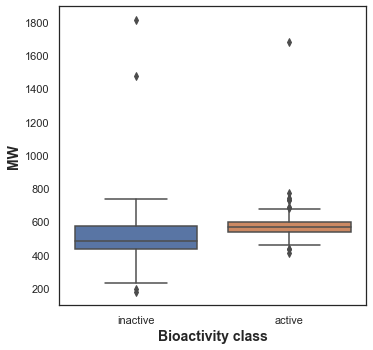

In [49]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

## 特征提取

1. 采用padel进行化合物fingerprint计算

此外，padel似乎也有python版本的：https://github.com/ecrl/padelpy

In [1]:
! unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [4]:
import pandas as pd
df=pd.read_csv("TP53_activity_data_3class_pIC50.csv",index_col=0)
df

E:\anaconda\envs\drug\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors,logIC50
0,CHEMBL179549,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,27000.0,inactive,572.822,7.17210,1.0,4.0,4.431380
1,CHEMBL360920,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,66000.0,inactive,426.560,5.48100,1.0,2.0,4.819551
2,CHEMBL182052,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,90000.0,inactive,445.515,4.26000,1.0,5.0,4.954247
3,CHEMBL179662,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,85000.0,inactive,449.594,5.02930,3.0,3.0,4.929424
4,CHEMBL181688,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,92000.0,inactive,461.605,7.05800,0.0,2.0,4.963793
...,...,...,...,...,...,...,...,...,...
1212,CHEMBL4465041,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,4.2,active,414.336,6.20654,1.0,2.0,0.716003
1213,CHEMBL3691737,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,130.0,intermediate,520.460,7.67774,0.0,4.0,2.117271
1214,CHEMBL3691738,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,506000.0,inactive,520.460,7.67774,0.0,4.0,5.704151
1215,CHEMBL3687315,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,130.0,intermediate,593.555,7.30972,0.0,6.0,2.117271


In [5]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [6]:
df_selection

,canonical_smiles,molecule_chembl_id
0,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)...,CHEMBL179549
1,CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccccc1)c1ccc(C(C)...,CHEMBL360920
2,CCCOC1(c2ccccc2)c2ccccc2C(=O)N1C(Cc1ccc(O)cc1)...,CHEMBL182052
3,OCC(NC1(c2ccccc2)c2ccccc2CC1Cc1ccccc1)C(O)c1cc...,CHEMBL179662
4,CC(C)(C)c1ccc(COC2(c3ccccc3)c3ccccc3C(=O)N2Cc2...,CHEMBL181688
...,...,...
1212,Cc1cc(Cl)ccc1C1c2c(C(C)C)n[nH]c2C(=O)N1c1cc(Cl...,CHEMBL4465041
1213,COc1ccccc1-n1nc2c(c1C(C)C)[C@H](c1ccc(Cl)cc1C)...,CHEMBL3691737
1214,COc1ccccc1-n1nc2c(c1C(C)C)[C@@H](c1ccc(Cl)cc1C...,CHEMBL3691738
1215,COc1ccccc1-n1nc2c(c1C(C)C)C(c1ccc(Cl)cc1C)N(c1...,CHEMBL3687315


### 使用java进行计算

每个化合物，共获取800多个features

```sh
java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv
```

In [7]:
padel_features= pd.read_csv('descriptors_output.csv')
padel_features

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL360719,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL182052,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL360920,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL360141,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL179549,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,CHEMBL4465041,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1213,CHEMBL1333839,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1214,CHEMBL3691737,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1215,CHEMBL3691738,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 使用python计算fingerPrint

In [1]:
!pip install padelpy -i https://pypi.douban.com/simple

Looking in indexes: https://pypi.douban.com/simple


In [3]:
from padelpy import from_smiles

In [4]:
fingerprints = from_smiles('CCCN1C(=O)c2ccccc2C1(NC(=O)c1ccc(C(C)(C)C)cc1)c1ccc(OCOCC[Si](C)(C)C)cc1', fingerprints=True, descriptors=False)

**批量预测**

In [1]:
from padelpy import padeldescriptor

In [3]:
# to calculate PubChem fingerprints
padeldescriptor(mol_dir="molecule.smi", 
                d_file="descriptors.csv",
                fingerprints=True,
                removesalt=True,
                standardizenitro=True,
                threads=2,
                log=True
               )

### 将features与因变量结合

In [10]:
padel_featuresX=padel_features.drop(columns=['Name'])
dataset = pd.concat([padel_featuresX,df['logIC50']], axis=1)
dataset

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,logIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431380
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.819551
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.954247
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.929424
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.963793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.716003
1213,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.117271
1214,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.704151
1215,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.117271


In [11]:
dataset.to_csv('TP53_Features_fp_IC50.csv', index=False)

## 建立ML model

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

E:\anaconda\envs\drug\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\anaconda\envs\drug\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
df = pd.read_csv('TP53_Features_fp_IC50.csv')
df

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,logIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.431380
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.819551
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.954247
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.929424
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4.963793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.716003
1213,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.117271
1214,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.704151
1215,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.117271


### X,Y features提取

In [3]:
X = df.drop('logIC50', axis=1)
X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1213,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1214,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1215,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [4]:
Y = df.logIC50
Y

0       4.431380
1       4.819551
2       4.954247
3       4.929424
4       4.963793
          ...   
1212    0.716003
1213    2.117271
1214    5.704151
1215    2.117271
1216    3.176381
Name: logIC50, Length: 1217, dtype: float64

### Features过滤

In [5]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold()    
X = selection.fit_transform(X)
X.shape

(1217, 515)

### Dataset 划分

从中获取train & test 数据集

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [7]:
X_train.shape,X_test.shape

((973, 515), (244, 515))

### Random Forest Regression Model

In [8]:
import numpy as np
import random
np.sqrt(515)

22.693611435820433

In [9]:
model = RandomForestRegressor(n_estimators=25)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.8156331889486836

### 可视化

In [10]:
Y_pred = model.predict(X_test)

E:\anaconda\envs\drug\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

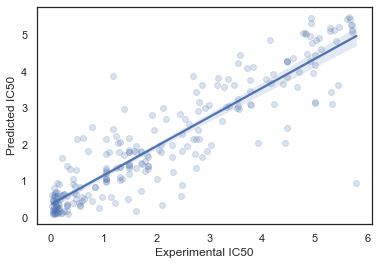

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.2})
ax.set_xlabel('Experimental IC50')
ax.set_ylabel('Predicted IC50')

plt.show

In [12]:
r=np.corrcoef(Y_test,Y_pred)
r[0, 1]

0.9041366312995432

In [13]:
import scipy.stats
scipy.stats.pearsonr(Y_test, Y_pred)

(0.9041366312995432, 2.3790261824421563e-91)

[Text(126.55284593799446, 212.26285714285714, 'X[106] <= 0.5\nmse = 3.029\nsamples = 616\nvalue = 2.021'),
 Text(52.67877027294304, 201.90857142857143, 'X[22] <= 0.5\nmse = 1.251\nsamples = 120\nvalue = 4.355'),
 Text(33.665135482594934, 191.5542857142857, 'X[37] <= 0.5\nmse = 0.921\nsamples = 106\nvalue = 4.576'),
 Text(12.27246835443038, 181.2, 'X[401] <= 0.5\nmse = 0.474\nsamples = 30\nvalue = 3.596'),
 Text(9.888607594936708, 170.84571428571428, 'X[436] <= 0.5\nmse = 0.17\nsamples = 4\nvalue = 4.223'),
 Text(9.182278481012657, 160.49142857142857, 'X[319] <= 0.5\nmse = 0.025\nsamples = 3\nvalue = 4.38'),
 Text(8.475949367088607, 150.13714285714286, 'X[19] <= 0.5\nmse = 0.003\nsamples = 2\nvalue = 4.488'),
 Text(7.769620253164557, 139.78285714285715, 'mse = 0.0\nsamples = 1\nvalue = 4.519'),
 Text(9.182278481012657, 139.78285714285715, 'mse = -0.0\nsamples = 1\nvalue = 4.398'),
 Text(9.888607594936708, 150.13714285714286, 'mse = 0.0\nsamples = 1\nvalue = 4.164'),
 Text(10.59493670886

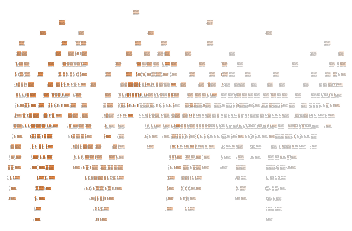

In [24]:
from sklearn import tree
tree.plot_tree(model.estimators_[0],filled=True)

## 比较不同Models

主要是使用 [lazypredict](https://github.com/shankarpandala/lazypredict) 实现多个ML Models的比较

In [14]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

E:\anaconda\envs\drug\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


### 分析结果

In [21]:
mlf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_x,predictions = mlf.fit(X_train, X_train, Y_train, Y_train)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:53<00:00,  1.27s/it]


In [22]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.93,0.97,0.31,0.09
ExtraTreeRegressor,0.93,0.97,0.31,0.08
ExtraTreesRegressor,0.93,0.97,0.31,3.39
GaussianProcessRegressor,0.93,0.97,0.31,1.45
XGBRegressor,0.91,0.96,0.35,1.08
MLPRegressor,0.90,0.95,0.38,1.40
RandomForestRegressor,0.89,0.95,0.38,2.26
BaggingRegressor,0.88,0.94,0.41,0.33
HistGradientBoostingRegressor,0.84,0.93,0.47,6.53


In [19]:
mlf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models_train,predictions_train = mlf.fit(X_train, X_test, Y_train, Y_test)
predictions_train

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:48<00:00,  1.16s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,599397030135288841118848506658816.00,-670930009040323304159791558950912.00,46078080168255544.00,0.33
RANSACRegressor,2692737803285840072278016.00,-3014093343595672687869952.00,3088404071652.34,12.47
TransformedTargetRegressor,1055434338271040035094528.00,-1181391522673756643262464.00,1933537914359.59,0.27
LinearRegression,1055434338271040035094528.00,-1181391522673756643262464.00,1933537914359.59,0.20
SGDRegressor,8233191089690468.00,-9215752989283156.00,170773775.62,0.05
KernelRidge,2.65,-0.85,2.42,0.07
GaussianProcessRegressor,2.58,-0.77,2.37,0.90
LassoLars,1.89,-0.00,1.78,0.05
DummyRegressor,1.89,-0.00,1.78,0.04


### 结果可视化

做四幅图进行结果可视化

In [28]:
df=predictions.head(10)
df

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.93,0.97,0.31,0.09
ExtraTreeRegressor,0.93,0.97,0.31,0.08
ExtraTreesRegressor,0.93,0.97,0.31,3.39
GaussianProcessRegressor,0.93,0.97,0.31,1.45
XGBRegressor,0.91,0.96,0.35,1.08
MLPRegressor,0.90,0.95,0.38,1.40
RandomForestRegressor,0.89,0.95,0.38,2.26
BaggingRegressor,0.88,0.94,0.41,0.33
HistGradientBoostingRegressor,0.84,0.93,0.47,6.53


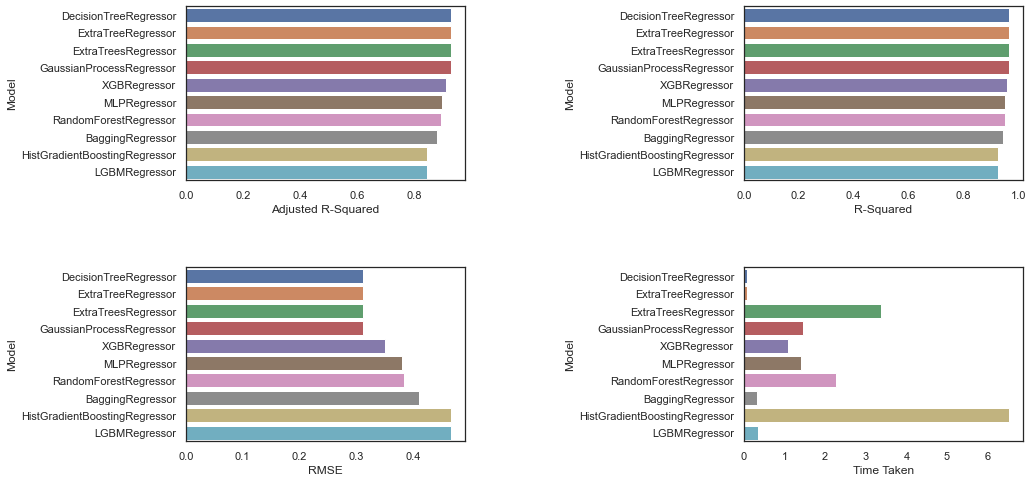

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

#sns.set(color_codes=True)
#sns.set_style("white")
fig=plt.figure(figsize=(15,8))
grid=plt.GridSpec(2,2,wspace=1,hspace=0.5,figure=fig)

ax1=fig.add_subplot(grid[0,0])
ax2=fig.add_subplot(grid[0,1])
ax3=fig.add_subplot(grid[1,0])
ax4=fig.add_subplot(grid[1,1])

sns.barplot(data=df, x='Adjusted R-Squared', y=df.index,ax=ax1)
sns.barplot(data=df, x='R-Squared', y=df.index,ax=ax2)
sns.barplot(data=df, x='RMSE', y=df.index,ax=ax3)
sns.barplot(data=df, x='Time Taken', y=df.index,ax=ax4)

plt.show()

Top3 best models:

+ DecisionTreeRegressor

+ ExtraTreeRegressor

+ ExtraTreesRegressor

Top3 best in test data:

+ RandomForestRegressor

+ GradientBoostingRegressor

+ LGBMRegressor

### Decision Tree Regressor

[DTR](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [76]:
model =  DecisionTreeRegressor()
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.7522247552825085